# E [$B_x \cdot B_y] $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
from scipy.stats import normaltest, gaussian_kde, probplot
from scipy.optimize import curve_fit
import time
from tqdm import tqdm

In [2]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

In [3]:
num_exp = 1000
noise_values = np.logspace(start = -8, stop = 2, num = 100)
summands_lists = [] * len(noise_values)
summands_means = np.zeros(len(noise_values))
B_xs = np.zeros((resolution, resolution, len(noise_values)))

total_sum_df = pd.DataFrame(columns=['Noise', 'Abs_Sum'])

for noise in tqdm(noise_values):
    for i in range(num_exp):
        # Randomly select image indexes and category indexes
        image_indexes = np.random.randint(0, 10, 2)
        category_indexes = np.random.randint(0, 10, 2)
        
        # Create image instances
        image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
        image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)
        
        # Process images
        results = Image.process_images(image1, image2, noise)
        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        sum_left = 0
        sum_right = 0
        k = np.random.randint(1, resolution + 1, size=2)
        
        # Calculate sum_left and sum_right according to line 44
        for x in range(resolution):
            for y in range(resolution):
                B_x = image1.image_post_noised[x, y] * alpha_1 - image2.image_post_noised[x, y] * alpha_2
                location = np.array([x, y])
                exponent = np.exp(-1j * np.dot(location, k))
                sum_left += exponent * B_x
                exponent = np.exp(1j * np.dot(location, k))
                sum_right += exponent * B_x
        
        # Compute absolute sum
        abs_sum = abs(sum_left * sum_right)
        
        # Append results to DataFrame
        total_sum_df = total_sum_df._append({
            'Noise': noise,
            'Sum_Left': sum_left,
            'Sum_Right': sum_right,
            'alpha_1': alpha_1,
            'alpha_2': alpha_2,
            'k': k,
            'Abs_Sum': abs_sum
        }, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_8136\723335502.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_sum_df = total_sum_df._append({
100%|██████████| 100/100 [25:49<00:00, 15.50s/it]


In [4]:
total_sum_df.to_csv('total_sum_df.csv', index=False)

In [5]:
total_sum_df.head()

,Noise,Abs_Sum,Sum_Left,Sum_Right,alpha_1,alpha_2,k
0,1.000000e-08,1.761397e-19,-9.107141e-11-4.096898e- 10j,-9.107141e-11+4.096898e- 10j,-1.341620e-07,-4.706376e-08,"[22, 2]"
1,1.000000e-08,1.461202e-18,-5.685059e-10+1.066772e- 09j,-5.685059e-10-1.066772e- 09j,-4.308885e-07,-1.023180e-07,"[15, 1]"
2,1.000000e-08,1.263253e-16,4.919992e-09-1.010540e- 08j,4.919992e-09+1.010540e- 08j,4.987910e-07,-1.191764e-07,"[29, 31]"
3,1.000000e-08,5.137144e-20,-2.251377e-10-2.616176e- 11j,-2.251377e-10+2.616176e- 11j,-7.105791e-09,1.057837e-08,"[8, 26]"
4,1.000000e-08,5.856907e-19,6.612201e-10+3.853293e- 10j,6.612201e-10-3.853293e- 10j,-2.579184e-08,-4.268931e-07,"[30, 3]"


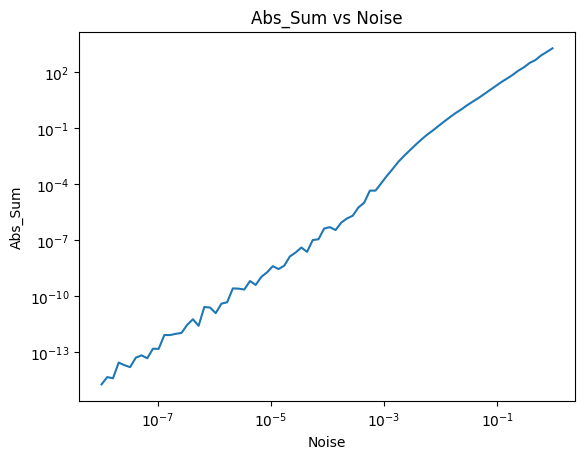

In [10]:
grouped = total_sum_df.groupby('Noise').mean().reset_index()
grouped = grouped[grouped['Noise'] < 1]

plt.plot(grouped['Noise'], grouped['Abs_Sum'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise')
plt.ylabel('Abs_Sum')
plt.title('Abs_Sum vs Noise')
plt.show()